Import libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate, Dropout, TextVectorization, LSTM, \
BatchNormalization, Activation, Lambda, MultiHeadAttention, LayerNormalization, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import backend as K
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

Load dataset

In [99]:
pd.set_option('display.max_columns', None)
#df = pd.read_csv('Merged_df.csv', index_col=0, low_memory=False)
df = pd.read_csv("/kaggle/input/merged-df/Merged_df.csv", index_col=0, low_memory=False)

Drop unnecessary columns [Not utilized in analysis]

In [100]:
df1 = df.drop(['MovieID', 'Timestamp', 'Title', 'Genres', 'ZipCode', 'Movie_Title',
               'status', 'backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'production_companies',  "overview", "tagline",
               'production_countries', 'title_year', 'year', 'original_language', "release_date", "original_title", "spoken_languages", "revenue", "budget"], axis=1)

Coerce Numerical Features which have values as 0 to NA 

In [101]:
# Define Numerical Features
numerical_features = ['vote_average', 'vote_count', 'runtime', 'popularity'] # Did not consider revenue and budget as there are lots of values which are 0

# Coerce '0' values to NA
df1[numerical_features] = df1[numerical_features].replace(0, pd.NA)

Drop rows with NA values

In [102]:
df1.dropna(inplace=True)

Convert 'adult' column to integers

In [103]:
# Convert 'adult' column to integers (1 for True, 0 for False)
df1['adult'] = df1['adult'].astype(int)

Convert movieids to integers

In [104]:
df1['id'] = df1['id'].astype(int)

Handle outliers in numerical columns

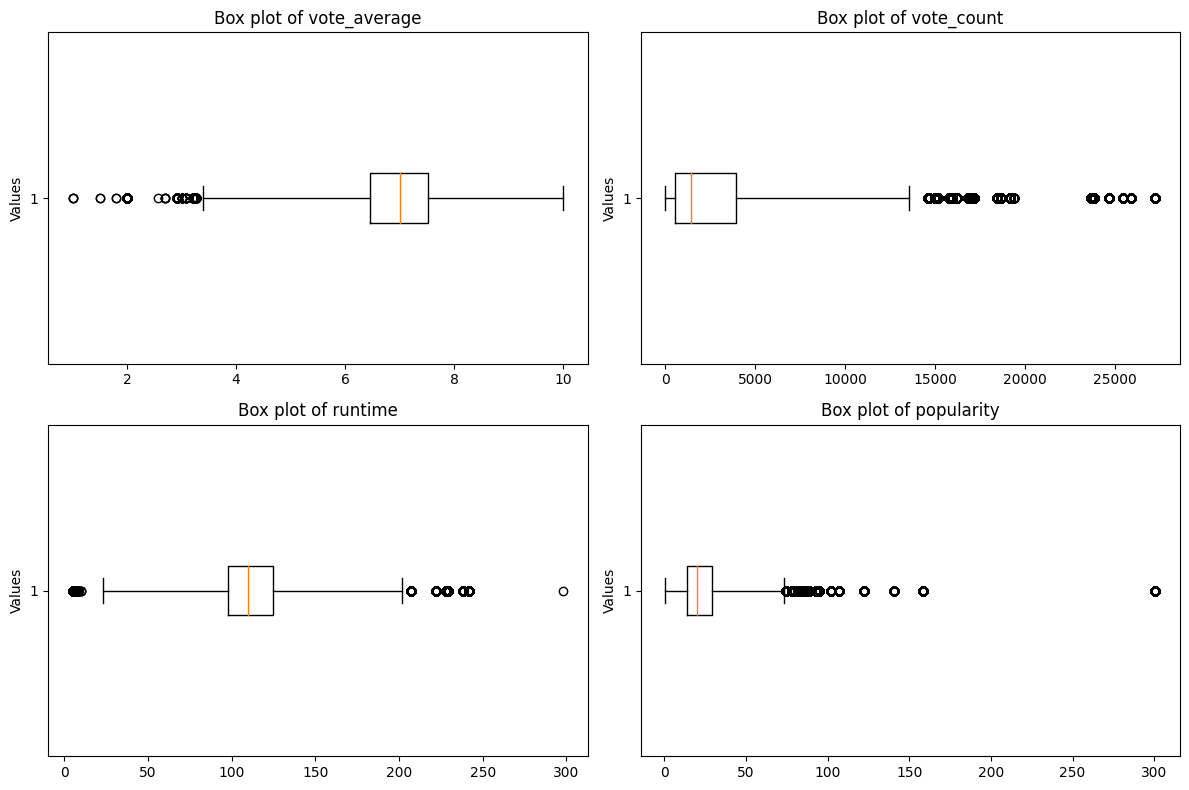

In [105]:
# Create a box plot for each column
plt.figure(figsize=(12, 8))  # Set the figure size for better readability

for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # This creates a 2x2 grid of subplots
    
    plt.boxplot(df1[column], whis=3, vert = False)
    #sns.boxplot(y=df_combined[column])
    plt.title(f'Box plot of {column}')  # Title for each subplot
    plt.ylabel('Values')  # Set the y-axis label

plt.tight_layout()
plt.show()

In [106]:
# Don't need to touch vote_average or vote_count

# Runtime can significantly skew results
runtime_q1 = df1["runtime"].quantile(0.25)
runtime_q3 = df1["runtime"].quantile(0.75)
runtime_iqr = runtime_q3 - runtime_q1

runtime_lowerbound = runtime_q1 - 3*runtime_iqr
runtime_upperbound = runtime_q3 + 3*runtime_iqr

# Remove Outliers if runtime falls outside 3 * IQR 
df1 = df1[(df1["runtime"] >= runtime_lowerbound) & (df1["runtime"] <= runtime_upperbound)]

# Capping outliers for popularity scores to 100
df1['popularity'] = df1['popularity'].apply(lambda x: 100 if x > 100 else x)

Encode Catgorical features & Scale Numerical Variables

In [107]:
# Define categorical and numerical features
categorical_features = ['Gender', 'Occupation', 'Age']

# One-Hot Encoding for categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Using sparse=False to get a dense array
encoded_features = one_hot_encoder.fit_transform(df1[categorical_features])

# Normalize Numerical Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df1[numerical_features])

Convert Genres into Multiple Binary Columns

In [108]:
# Since genres are separated by commas in dataset
df1['genres'] = df1['genres'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df1['genres'])

Before concatenating, Drop all original variables which have been transformed

In [109]:
df1.drop(categorical_features, axis=1, inplace=True)
df1.drop(numerical_features, axis=1, inplace=True)
df1.drop("genres", axis=1, inplace=True)

Combine all processed features back into one dataframe

In [110]:
# Convert encoded categorical features, scaled numerical features, and multiple genere features back to DataFrame 
encoded_cats = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=df1.index)
scaled_nums = pd.DataFrame(scaled_features, columns=numerical_features, index=df1.index)
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df1.index)

# Combine all features
df_combined = pd.concat([df1, encoded_cats, scaled_nums,genres_df], axis=1)

Split into train and test dataset

In [111]:
df_train_combined, df_test_combined = train_test_split(df_combined, test_size=0.2, random_state=42)

Create User embeddings

In [154]:
num_users = df_train_combined['UserID'].max() + 1  # Add 1 to handle index error as python indexes from 0, then index 0 will be unused/reserved

# UsedID embeddings
user_id_input = Input(shape=(1,), name='user_id_input')  # Entry point for User IDs  --> Each input is a single value

# Aim to capture 15 latent characteristics of each user (15 dimensions)
# input_dim is the total number of unique users
user_embedding = Embedding(input_dim=num_users, output_dim=15, name='user_embedding')(user_id_input) # Transforms each userID into a dense vector of size 15
user_flatten = Flatten(name='user_flatten')(user_embedding) # Flatten to a 1D tensor

User demographics

In [155]:
demographic_features = ['Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1', 'Occupation_2',
                        'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
                        'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
                        'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
                        'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
                        'Occupation_19', 'Occupation_20', 'Age_1', 'Age_18', 'Age_25', 'Age_35',
                        'Age_45', 'Age_50', 'Age_56']

# User demographics input
user_demographics_input = Input(shape=(len(demographic_features),), name='user_demographics_input')

Create Movie Embeddings

In [157]:
num_movies = df_train_combined['id'].max() + 1 # Add 1 to handle index error as python indexes from 0, then index 0 will be unused/reserved

# MovieID embeddings
movie_id_input = Input(shape=(1,), name='movie_id_input')  # Entry point for Movie IDs  --> Each input is a single value

# Aim to capture 50 latent characteristics of each movie due to large number of unique movies (50 dimensions)
# input_dim is the total number of unique movies
movie_embedding = Embedding(input_dim=num_movies, output_dim=15, name='movie_embedding')(movie_id_input)
movie_flatten = Flatten(name='movie_flatten')(movie_embedding)

Movie Features

In [158]:
movie_features_columns = ['vote_average', 'vote_count', 'runtime', 'popularity',
                          'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
                          'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
                          'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'adult']

num_movie_features = len(movie_features_columns)

movie_input = Input(shape=(num_movie_features,), name='movie_input')

In [159]:
# Dot Product of embeddings for collaborative filtering
cf_pred = Dot(axes=1)([user_flatten, movie_flatten])

Combine model inputs

In [160]:
# Combine user and movie inputs
combined_inputs = concatenate([cf_pred, user_demographics_input, movie_input])

Assemble Complete Model

In [161]:
# Add fully connected layers
fc1 = Dense(256, activation='relu')(combined_inputs) 
dropout1 = Dropout(0.25)(fc1)

fc2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.25)(fc2)

fc3 = Dense(64, activation='relu')(dropout2)
output = Dense(1, activation='sigmoid')(fc3) 
output =Lambda(lambda x: x * 5)(output)

# Finalizing the model
model = Model(inputs=[user_id_input, user_demographics_input, movie_id_input, movie_input], outputs=output)
lr_schedule = ExponentialDecay(initial_learning_rate=0.004, decay_steps=10000, decay_rate=0.9) # Learning Rate Scheduling

# Compiling the model
model.compile(optimizer=Adam(lr_schedule), loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 15)     │     90,615 │ user_id_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 15)     │ 16,160,415 │ movie_id_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 15)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_flatten       │ (None, 15)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ user_flatten[0][… │
│                     │                   │            │ movie_flatten[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_demographics_… │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 55)        │          0 │ dot_5[0][0],      │
│ (Concatenate)       │                   │            │ user_demographic… │
│                     │                   │            │ movie_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │     14,336 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     32,896 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      8,256 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         65 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ dense_31[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,306,583 (62.20 MB)

 Trainable params: 16,306,583 (62.20 MB)

 Non-trainable params: 0 (0.00 B)

Preparing Inputs for training

In [162]:
# Extract ratings (Y-values)
ratings_train = df_train_combined['Rating'].values
ratings_test = df_test_combined['Rating'].values

# Prepare inputs for training
user_ids_train = df_train_combined['UserID'].values
movie_ids_train = df_train_combined['id'].values
user_demographics_train = df_train_combined[demographic_features].values
movie_features_train = df_train_combined[movie_features_columns].values

# Prepare inputs for testing (evaluation)
user_ids_test = df_test_combined['UserID'].values
movie_ids_test = df_test_combined['id'].values
user_demographics_test = df_test_combined[demographic_features].values
movie_features_test = df_test_combined[movie_features_columns].values

Train the Model

In [163]:
history = model.fit([user_ids_train, user_demographics_train, movie_ids_train, movie_features_train], ratings_train,
                    validation_data=([user_ids_test, user_demographics_test, movie_ids_test, movie_features_test], ratings_test),
                    epochs=5,
                    batch_size=128)

Epoch 1/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.9890 - val_loss: 0.8092
Epoch 2/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.7470 - val_loss: 0.7882
Epoch 3/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.6712 - val_loss: 0.7860
Epoch 4/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.6312 - val_loss: 0.7839
Epoch 5/5
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.6098 - val_loss: 0.7734


Process TMDB Dataset

In [189]:
# Load Dataset
tmdb_df = pd.read_csv("/kaggle/input/tmdb-movies/TMDB_movie_dataset_v11.csv", index_col=0, low_memory=False)

# Cleaning up the release date column to coerce problematic values to NaT, and ensure dates are in proper format
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce')

# Creating new "year" (string) column and extracting year from the "release_date" field
tmdb_df['year'] = tmdb_df['release_date'].dt.year.astype('Int64').astype(str).replace('<NA>', pd.NA)

# Drop unnecessary columns not used in analysis
tmdb_df1 = tmdb_df.drop(['status', 'backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries', 'release_date', 
                         'original_language', "original_title", "spoken_languages", "overview", "tagline", "revenue", "budget"], axis=1)

Check and handle outliers for numerical features

In [190]:
# Coerce '0' values to NA for numerical features
tmdb_df1[numerical_features] = tmdb_df1[numerical_features].replace(0, pd.NA)

features_with_na = numerical_features + ["year"]

# Drop rows with 0 for numerical features (as it will skew/bias the results if included)
tmdb_df1 = tmdb_df1.dropna(subset=features_with_na)

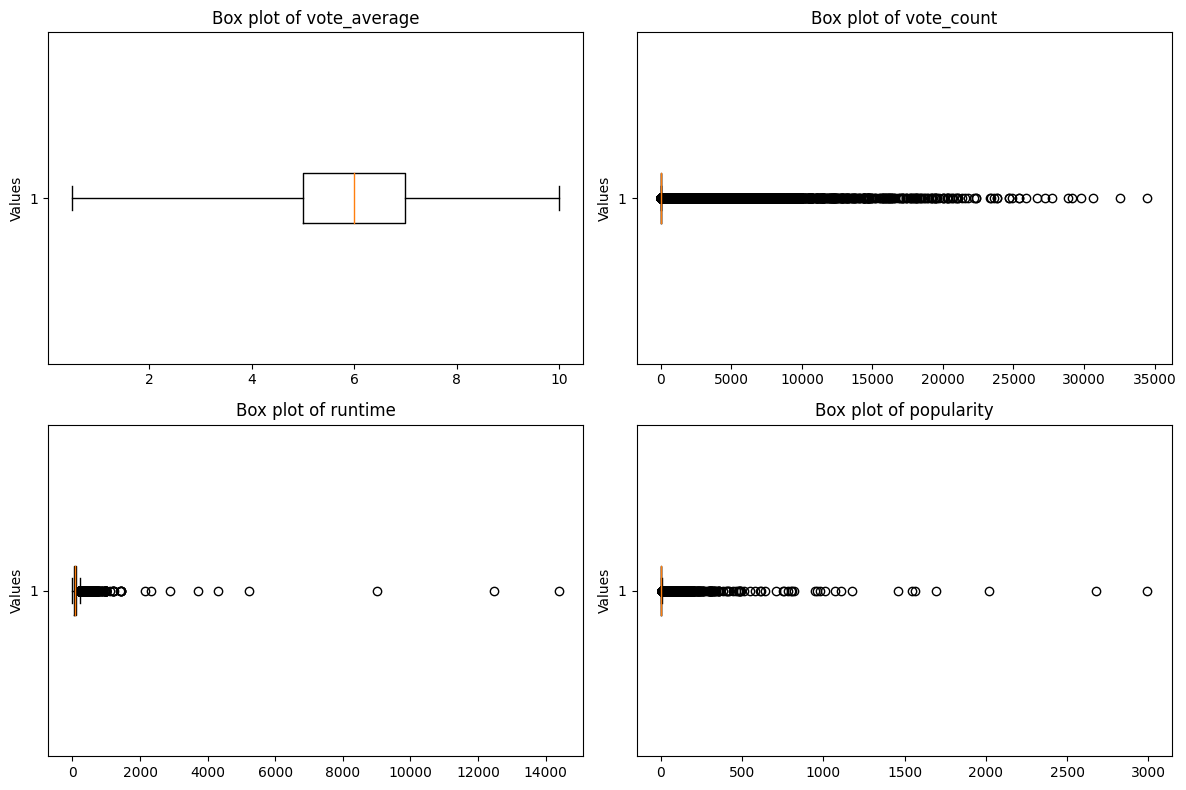

In [191]:
# Create a box plot for each numerical feature
plt.figure(figsize=(12, 8))  # Set the figure size for better readability

for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # This creates a 2x2 grid of subplots
    
    plt.boxplot(tmdb_df1[column], whis=3, vert = False)
    plt.title(f'Box plot of {column}')  # Title for each subplot
    plt.ylabel('Values')  # Set the y-axis label

plt.tight_layout()
plt.show()

In [192]:
# Don't need to touch vote_average or vote_count

# Runtime can significantly skew results
runtime_q1_tmdb = tmdb_df1["runtime"].quantile(0.25)
runtime_q3_tmdb = tmdb_df1["runtime"].quantile(0.75)
runtime_iqr_tmdb = runtime_q3_tmdb - runtime_q1_tmdb

runtime_lowerbound_tmdb = runtime_q1_tmdb - 3*runtime_iqr_tmdb
runtime_upperbound_tmdb = runtime_q3_tmdb + 3*runtime_iqr_tmdb

# Remove Outliers if runtime falls outside 3 * IQR 
tmdb_df1 = tmdb_df1[(tmdb_df1["runtime"] >= runtime_lowerbound_tmdb) & (tmdb_df1["runtime"] <= runtime_upperbound_tmdb)]

# Capping outliers for popularity scores to 100
tmdb_df1.loc[:,'popularity'] = tmdb_df1['popularity'].apply(lambda x: 100 if x > 100 else x)

Convert "Adult" column to binary

In [193]:
# Convert 'adult' column to integers (1 for True, 0 for False)
tmdb_df1['adult'] = tmdb_df1['adult'].astype(int)

Scaling and encoding genres

In [194]:
# Scale numerical features
scaled_features1 = scaler.transform(tmdb_df1[numerical_features])
scaled_nums1 = pd.DataFrame(scaled_features1, columns=numerical_features, index=tmdb_df1.index)

# Have multiple genres and one hot encode it
tmdb_df1.loc[:,'genres'] = tmdb_df1['genres'].astype(str)
tmdb_df1.loc[:,'genres'] = tmdb_df1['genres'].apply(lambda x: x.split(', ') if x != 'nan' else [])
genres_encoded1 = mlb.transform(tmdb_df1['genres'])
genres_df1 = pd.DataFrame(genres_encoded1, columns=mlb.classes_, index=tmdb_df1.index)

# Drop Original features
tmdb_df1 = tmdb_df1.drop(numerical_features, axis=1)
tmdb_df1 = tmdb_df1.drop("genres", axis=1)

# Concat all new features
tmdb_df2 = pd.concat([tmdb_df1, scaled_nums1, genres_df1], axis=1)

Predict top K Movies for a particular user (with diversity)

In [236]:
def predict_top_movies(user_id, year_onwards = 0, data2 = tmdb_df2, num_recommendations=5, model = model, data1 = df_combined):
    
    # Extract user IDs
    user_id_input = np.array([user_id] * len(data2))
    
    # Extract dataset for this particular user and just keep first row as features will be constant
    user_df = data1[data1['UserID'] == user_id][:1]

    # Extract users demographic features and repeat for the length of unseen movies
    user_demographics_pred = np.repeat(user_df[demographic_features].values, len(data2), axis=0)
    
    # Extract Movie IDs
    movie_id_input = data2.index.values
    
    # Extract Movie features input
    movie_features_input = data2[movie_features_columns].values
    
    # Predict Ratings for unseen movies
    predicted_ratings = model.predict([user_id_input, user_demographics_pred, movie_id_input, movie_features_input])
    
    new_df = data2.copy()
    
    new_df["predicted_ratings"] = predicted_ratings  
    
    # Apply a year filter if specified
    if year_onwards != 0:
        new_df["year"] = new_df["year"].astype('Int64')
        new_df = new_df[new_df["year"] >= year_onwards]
        
    # Select the top (k-1) and next 10 candidates
    top_recommendations = new_df.nlargest(num_recommendations + 10, 'predicted_ratings')
    top_k = top_recommendations.head(num_recommendations-1)
    next_candidates = top_recommendations.tail(10).copy()
    
    genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
                     'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
    
    # Calculate the average genre vector of the top 4
    top_4_genres = next_candidates[genre_columns].mean() # Column wise
    
    # Calculate dissimilarity (Euclidean distance) from the top 4's genre vector
    next_candidates.loc[:, "dissimilarity"] = next_candidates[genre_columns].apply(lambda row: np.linalg.norm(row - top_4_genres), axis=1)
        
    # Select the most diverse movie from the candidates
    most_diverse_movie = next_candidates.nlargest(1, 'dissimilarity')
    
    # Combine the top 4 with the most diverse movie
    final_recommendations = pd.concat([top_k, most_diverse_movie]).reset_index(drop=True)

    final_movies_df = final_recommendations[["title", "year", "predicted_ratings"]]
    

    return final_movies_df

Check predictions for User 73

In [237]:
predict_top_movies(73)

9243/9243 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,title,year,predicted_ratings
0,Skunk Ape Unit Escape from Nack Ba,2022,4.755037
1,The Zelenskyy Interview: David Muir Reporting,2022,4.754623
2,The Geek Temple,1992,4.753805
3,Guns in America: From Buffalo to Uvalde,2022,4.751108
4,Heidi's Alpine Dream,2022,4.749352


Check predictions for User 4066

In [238]:
predict_top_movies(4066)

9243/9243 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,title,year,predicted_ratings
0,Reimagining A Buffalo Landmark,2019,4.528969
1,From Runes to Ruins,2014,4.528292
2,The Kill,1952,4.522571
3,Kamala Harris To Be The First,2020,4.518864
4,Aliens do terceiro mundo e o sequestro de Dona...,2022,4.492392


Check predictions for User 1738

In [239]:
predict_top_movies(1738)

9243/9243 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,title,year,predicted_ratings
0,For All Mankind,1989,4.771067
1,Dr. Strangelove or: How I Learned to Stop Worr...,1964,4.759318
2,Heidi's Alpine Dream,2022,4.708308
3,The Fondas: A Cinematic Dynasty,2023,4.708297
4,Pather Panchali,1955,4.701484


Predictions for Brand New Users (For Cold Start Problem)

In [242]:
# Function to get users input for new users to predict based on their demographic features
def get_user_input():
    print("Please enter your demographic information:")
    
    # Display gender choices
    print("Gender is denoted by a 'M' for male and 'F' for female.")
    gender = input("Gender (F/M): ").strip().upper()
    
    # Display age choices
    print("\nAge is chosen from the following ranges:")
    print("  1: 'Under 18'")
    print(" 18: '18-24'")
    print(" 25: '25-34'")
    print(" 35: '35-44'")
    print(" 45: '45-49'")
    print(" 50: '50-55'")
    print(" 56: '56+'")
    age = int(input("Enter the number corresponding to your age group: "))
    
    # Display occupation choices
    print("\nOccupation is chosen from the following choices:")
    print("  0: 'other' or not specified")
    print("  1: 'academic/educator'")
    print("  2: 'artist'")
    print("  3: 'clerical/admin'")
    print("  4: 'college/grad student'")
    print("  5: 'customer service'")
    print("  6: 'doctor/health care'")
    print("  7: 'executive/managerial'")
    print("  8: 'farmer'")
    print("  9: 'homemaker'")
    print(" 10: 'K-12 student'")
    print(" 11: 'lawyer'")
    print(" 12: 'programmer'")
    print(" 13: 'retired'")
    print(" 14: 'sales/marketing'")
    print(" 15: 'scientist'")
    print(" 16: 'self-employed'")
    print(" 17: 'technician/engineer'")
    print(" 18: 'tradesman/craftsman'")
    print(" 19: 'unemployed'")
    print(" 20: 'writer'")
    occupation = int(input("Enter the number corresponding to your occupation: "))
    
    # Convert inputs to model-compatible format (one-hot encoding)
    user_data = np.zeros((1, 30))  # 30 features as per your model
    if gender == 'F':
        user_data[0, 0] = 1  # Gender_F
    else:
        user_data[0, 1] = 1  # Gender_M

    # Set occupation (assuming 0-20 are correctly input)
    user_data[0, 2 + occupation] = 1

    # Set age
    age_indices = {1: 23, 18: 24, 25: 25, 35: 26, 45: 27, 50: 28, 56: 29}
    user_data[0, age_indices[age]] = 1

    return user_data

# Function to recommend movies for new users
def recommend_movies_for_new_user(year_onwards = 0, data2 = tmdb_df2, num_recommendations=5, model = model, data1 = df_combined):
    
    # initialize random user id = 10000 (does not exist in data)
    user_id_input = np.array([10000] * len(data2))
    
    # Get user demographic features
    user_data = get_user_input()
    user_demographics_pred = np.repeat(user_data, len(data2), axis=0)
    
    # Extract Movie IDs
    movie_id_input = data2.index.values
    # Extract Movie features input
    movie_features_input = data2[movie_features_columns].values
    
    # Predict Ratings for unseen movies
    predicted_ratings = model.predict([user_id_input, user_demographics_pred, movie_id_input, movie_features_input])
    
    new_df = data2.copy()
    
    new_df["predicted_ratings"] = predicted_ratings  
    
    # Apply a year filter if specified
    if year_onwards != 0:
        new_df["year"] = new_df["year"].astype('Int64')
        new_df = new_df[new_df["year"] >= year_onwards]
        
    # Select the top (k-1) and next 10 candidates
    top_recommendations = new_df.nlargest(num_recommendations + 10, 'predicted_ratings')
    top_k = top_recommendations.head(num_recommendations-1)
    next_candidates = top_recommendations.tail(10).copy()
    
    genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
                     'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
    
    # Calculate the average genre vector of the top 4
    top_4_genres = next_candidates[genre_columns].mean() # Column wise
    
    # Calculate dissimilarity (Euclidean distance) from the top 4's genre vector
    next_candidates.loc[:, "dissimilarity"] = next_candidates[genre_columns].apply(lambda row: np.linalg.norm(row - top_4_genres), axis=1)
        
    # Select the most diverse movie from the candidates
    most_diverse_movie = next_candidates.nlargest(1, 'dissimilarity')
    
    # Combine the top 4 with the most diverse movie
    final_recommendations = pd.concat([top_k, most_diverse_movie]).reset_index(drop=True)

    final_movies_df = final_recommendations[["title", "year", "predicted_ratings"]]
    

    return final_movies_df

Test for new user 1 [M, 18, 25]

In [243]:
recommend_movies_for_new_user()

Please enter your demographic information:
Gender is denoted by a 'M' for male and 'F' for female.


Gender (F/M):  M



Age is chosen from the following ranges:
  1: 'Under 18'
 18: '18-24'
 25: '25-34'
 35: '35-44'
 45: '45-49'
 50: '50-55'
 56: '56+'


Enter the number corresponding to your age group:  25



Occupation is chosen from the following choices:
  0: 'other' or not specified
  1: 'academic/educator'
  2: 'artist'
  3: 'clerical/admin'
  4: 'college/grad student'
  5: 'customer service'
  6: 'doctor/health care'
  7: 'executive/managerial'
  8: 'farmer'
  9: 'homemaker'
 10: 'K-12 student'
 11: 'lawyer'
 12: 'programmer'
 13: 'retired'
 14: 'sales/marketing'
 15: 'scientist'
 16: 'self-employed'
 17: 'technician/engineer'
 18: 'tradesman/craftsman'
 19: 'unemployed'
 20: 'writer'


Enter the number corresponding to your occupation:  4


9243/9243 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,title,year,predicted_ratings
0,Grand Illusion,1937,4.825299
1,Casablanca,1943,4.781193
2,2001: A Space Odyssey,1968,4.759290
3,Citizen Kane,1941,4.745928
4,Double Indemnity,1944,4.631219


Test user 2 [F, 56, 20]

In [244]:
recommend_movies_for_new_user()

Please enter your demographic information:
Gender is denoted by a 'M' for male and 'F' for female.


Gender (F/M):  F



Age is chosen from the following ranges:
  1: 'Under 18'
 18: '18-24'
 25: '25-34'
 35: '35-44'
 45: '45-49'
 50: '50-55'
 56: '56+'


Enter the number corresponding to your age group:  56



Occupation is chosen from the following choices:
  0: 'other' or not specified
  1: 'academic/educator'
  2: 'artist'
  3: 'clerical/admin'
  4: 'college/grad student'
  5: 'customer service'
  6: 'doctor/health care'
  7: 'executive/managerial'
  8: 'farmer'
  9: 'homemaker'
 10: 'K-12 student'
 11: 'lawyer'
 12: 'programmer'
 13: 'retired'
 14: 'sales/marketing'
 15: 'scientist'
 16: 'self-employed'
 17: 'technician/engineer'
 18: 'tradesman/craftsman'
 19: 'unemployed'
 20: 'writer'


Enter the number corresponding to your occupation:  20


9243/9243 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


,title,year,predicted_ratings
0,Grand Illusion,1937,4.817448
1,Casablanca,1943,4.787938
2,The Girl on the Bridge,1999,4.767355
3,West Beirut,1998,4.762562
4,2001: A Space Odyssey,1968,4.701576
